# Summary

Focusing only on gene_id, submit the average value of gene_id.

In this case, cell_id is not used.

# Data preparation

I referred to [@peterholderrieth](https://www.kaggle.com/peterholderrieth)'s notebook. (https://www.kaggle.com/code/peterholderrieth/getting-started-data-loading)

In [55]:
!pip3 install --quiet tables
!pip3 install seaborn
!pip3 install colorama
!pip3 install lightgbm

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [56]:
import os
import lightgbm as lgb

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
import os, gc, pickle


In [23]:
os.listdir("/root/ml/multimodel")

['test_cite_inputs.h5',
 'train_multi_targets.h5',
 'metadata.csv',
 'evaluation_ids.csv',
 'sample_submission.csv',
 'train_cite_inputs.h5',
 'test_multi_inputs.h5',
 'train_multi_inputs.h5',
 'train_cite_targets.h5']

In [24]:
DATA_DIR = "/root/ml/multimodel"

SUBMISSON = os.path.join(DATA_DIR,"sample_submission.csv")

EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

## loading the common meta data table

In [34]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

In [35]:
df_cell

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...,...
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome


In [36]:
df_cell_cite

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...,...
119646,a9b4d99f1f50,7,31800,HSC,citeseq
119647,0e2c1d0782af,7,31800,HSC,citeseq
119648,a3cbc5aa0ec3,7,31800,MkP,citeseq
119649,75b350243add,7,31800,EryP,citeseq


In [37]:
df_cell_multi

,cell_id,day,donor,cell_type,technology
119651,458c2ae2c9b1,2,27678,hidden,multiome
119652,01a0659b0710,2,27678,hidden,multiome
119653,028a8bc3f2ba,2,27678,hidden,multiome
119654,7ec0ca8bb863,2,27678,hidden,multiome
119655,caa0b0022cdc,2,27678,hidden,multiome
...,...,...,...,...,...
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome


### scoring function

In [40]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

## Citeseq

#### preprocess citeseq data

(70988, 22050)
(70988, 21601)
(70988, 11601)


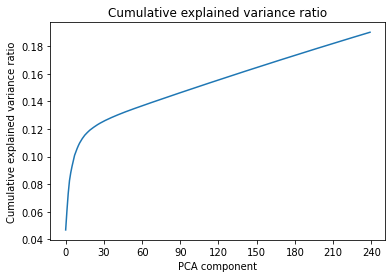

(70988, 240)
cite train y shape (70988, 140)
cite train x shape (70988, 240)
CPU times: user 3min 11s, sys: 1min 15s, total: 4min 26s
Wall time: 31.6 s


In [57]:
%%time
# Preprocessing
col_start = 10000

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 13000
    
    @staticmethod
    def take_column_subset(X):
        return X[:,-(PreprocessCiteseq.columns_to_use+col_start):-col_start]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print('cite train y shape', cite_train_y.shape)
print('cite train x shape', cite_train_x.shape)

In [46]:
pd.read_hdf(FP_CITE_TRAIN_INPUTS)

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [47]:
pd.read_hdf(FP_CITE_TRAIN_TARGETS)

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.905420,0.386141,0.961590,5.090580,2.854346,6.093729,-0.586178,0.452389,0.040806,0.191407,...,1.261118,3.092832,0.003275,0.278930,-0.272002,0.249477,3.789460,0.138330,1.466193,4.278504
cc506e7707f5,2.101247,2.117462,0.112699,2.065512,2.176803,3.900090,-0.586001,-0.175479,1.363232,0.109905,...,0.714624,5.029233,0.909861,0.057322,2.633387,1.340077,11.456146,-1.431453,5.275882,2.510530
a91f1b55a520,1.221313,0.476566,1.437551,5.135631,2.926102,1.615081,-0.586910,1.760421,1.944711,-0.095096,...,-0.176027,5.027534,-0.703609,1.139491,-0.078092,1.592960,9.358179,0.981883,6.911032,3.415310


### build training model

In [58]:
params={'learning_rate': 0.05,
        'objective':'mae', 
        'metric':'mae',
        'num_leaves': 64,
        'verbose': -1 ,
        "seed": 42,
#         'bagging_fraction': 0.7,
#         'feature_fraction': 0.7
       }
model = MultiOutputRegressor(lgb.LGBMRegressor(**params, n_estimators=1000))

model.fit(cite_train_x, cite_train_y)

y_va_pred = model.predict(cite_train_x)
mse = mean_squared_error(cite_train_y, y_va_pred)
print(mse)
del cite_train_x, cite_train_y
gc.collect()

1.826920722723093


3562

In [59]:
cite_test_x = preprocessor.transform(pd.read_hdf(FP_CITE_TEST_INPUTS).values)
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

(48663, 22050)
(48663, 21601)
(48663, 11601)
(48663, 240)


(48663, 140)

In [60]:
with open('/root/ml/submission/citeseq_pred.pickle', 'wb') as f: pickle.dump(test_pred, f) # float32 array of shape (48663, 140)


## Multiome

### preprocess multiome data

(6000, 228942)
(6000, 213532)
(6000, 4000)


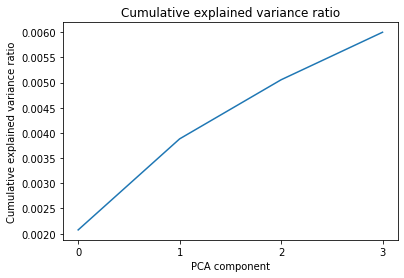

(6000, 4)
(6000, 23418)


In [62]:
#%%time
# Preprocessing

class PreprocessMultiome(BaseEstimator, TransformerMixin):
    columns_to_use = slice(10000, 14000)
    
    @staticmethod
    def take_column_subset(X):
        return X[:,PreprocessMultiome.columns_to_use]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=4, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessMultiome()

multi_train_x = None
start, stop = 0, 6000
multi_train_x = preprocessor.fit_transform(pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=start, stop=stop).values)

multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=start, stop=stop)
y_columns = multi_train_y.columns
multi_train_y = multi_train_y.values
print(multi_train_y.shape)

In [63]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(multi_train_x)):
    model = None
    gc.collect()
    X_tr = multi_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = multi_train_y[idx_tr]
    del idx_tr

    model = Ridge(copy_X=False)
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = multi_train_x[idx_va]
    y_va = multi_train_y[idx_va]
    del idx_va
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}{multi_train_x.shape} Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

Fold 0: mse = 1.99765, corr =  0.682
Fold 1: mse = 1.99460, corr =  0.681
Fold 2: mse = 1.99587, corr =  0.682
Fold 3: mse = 1.99645, corr =  0.682
Fold 4: mse = 1.99872, corr =  0.681
(6000, 4) Average  mse = 1.99666; corr = 0.682
CPU times: user 9.58 s, sys: 14.9 s, total: 24.5 s
Wall time: 4.18 s


#### retraining

In [64]:
# We retrain the model and then delete the training data, which is no longer needed
model, score_list, result_df = None, None, None # free the RAM occupied by the old model
gc.collect()
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(multi_train_x, multi_train_y)
del multi_train_x, multi_train_y # free the RAM
_ = gc.collect()

In [65]:
%%time
# Read the table of rows and columns required for submission
eval_ids = pd.read_csv(FP_EVALUATION_IDS, index_col='row_id')

# Convert the string columns to more efficient categorical types
#eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())
display(eval_ids)

# Create the set of needed cell_ids
cell_id_set = set(eval_ids.cell_id)

# Convert the string gene_ids to a more efficient categorical dtype
y_columns = pd.CategoricalIndex(y_columns, dtype=eval_ids.gene_id.dtype, name='gene_id')

,cell_id,gene_id
row_id,,
0,c2150f55becb,CD86
1,c2150f55becb,CD274
2,c2150f55becb,CD270
3,c2150f55becb,CD155
4,c2150f55becb,CD112
...,...,...
65744175,2c53aa67933d,ENSG00000134419
65744176,2c53aa67933d,ENSG00000186862
65744177,2c53aa67933d,ENSG00000170959


CPU times: user 21 s, sys: 2.02 s, total: 23 s
Wall time: 23.5 s


In [66]:
# Prepare an empty series which will be filled with predictions
submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
submission

cell_id       gene_id        
c2150f55becb  CD86              NaN
              CD274             NaN
              CD270             NaN
              CD155             NaN
              CD112             NaN
                                 ..
2c53aa67933d  ENSG00000134419   NaN
              ENSG00000186862   NaN
              ENSG00000170959   NaN
              ENSG00000107874   NaN
              ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [67]:
%%time
# Process the test data in chunks of 5000 rows

start = 0
chunksize = 5000
total_rows = 0
while True:
    multi_test_x = None # Free the memory if necessary
    gc.collect()
    # Read the 5000 rows and select the 30 % subset which is needed for the submission
    multi_test_x = pd.read_hdf(FP_MULTIOME_TEST_INPUTS, start=start, stop=start+chunksize)
    rows_read = len(multi_test_x)
    needed_row_mask = multi_test_x.index.isin(cell_id_set)
    multi_test_x = multi_test_x.loc[needed_row_mask]
    
    # Keep the index (the cell_ids) for later
    multi_test_index = multi_test_x.index
    
    # Predict
    multi_test_x = multi_test_x.values
    multi_test_x = preprocessor.transform(multi_test_x)
    test_pred = model.predict(multi_test_x)
    
    # Convert the predictions to a dataframe so that they can be matched with eval_ids
    test_pred = pd.DataFrame(test_pred,
                             index=pd.CategoricalIndex(multi_test_index,
                                                       dtype=eval_ids.cell_id.dtype,
                                                       name='cell_id'),
                             columns=y_columns)
    gc.collect()
    
    # Fill the predictions into the submission series row by row
    for i, (index, row) in enumerate(test_pred.iterrows()):
        row = row.reindex(eval_ids.gene_id[eval_ids.cell_id == index])
        submission.loc[index] = row.values
    print('na:', submission.isna().sum())

    #test_pred_list.append(test_pred)
    total_rows += len(multi_test_x)
    print(total_rows)
    if rows_read < chunksize: break # this was the last chunk
    start += chunksize
    
del multi_test_x, multi_test_index, needed_row_mask

(1533, 228942)
(1533, 213532)
(1533, 4000)
(1533, 4)
na: 60360284
1533
(1486, 228942)
(1486, 213532)
(1486, 4000)
(1486, 4)
na: 55141452
3019
(1517, 228942)
(1517, 213532)
(1517, 4000)
(1517, 4)
na: 49813748
4536
(1528, 228942)
(1528, 213532)
(1528, 4000)
(1528, 4)
na: 44447412
6064
(1492, 228942)
(1492, 213532)
(1492, 4000)
(1492, 4)
na: 39207508
7556
(1506, 228942)
(1506, 213532)
(1506, 4000)
(1506, 4)
na: 33918436
9062
(1490, 228942)
(1490, 213532)
(1490, 4000)
(1490, 4)
na: 28685556
10552
(1492, 228942)
(1492, 213532)
(1492, 4000)
(1492, 4)
na: 23445652
12044
(1475, 228942)
(1475, 213532)
(1475, 4000)
(1475, 4)
na: 18265452
13519
(1473, 228942)
(1473, 213532)
(1473, 4000)
(1473, 4)
na: 13092276
14992
(1499, 228942)
(1499, 213532)
(1499, 4000)
(1499, 4)
na: 7827788
16491
(289, 228942)
(289, 213532)
(289, 4000)
(289, 4)
na: 6812820
16780
CPU times: user 29min 16s, sys: 39.3 s, total: 29min 56s
Wall time: 29min 32s


In [68]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'
with open("/root/ml/submission/partial_submission_multi.pickle", 'wb') as f: pickle.dump(submission, f)
submission

row_id
0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
              ...   
65744175    7.271666
65744176    0.017597
65744177    0.025040
65744178    1.933743
65744179    5.111444
Name: target, Length: 65744180, dtype: float32

### create submission

In [71]:
with open("/root/ml/submission/partial_submission_multi.pickle", 'rb') as f: submission = pickle.load(f)
with open("/root/ml/submission/citeseq_pred.pickle", 'rb') as f: test_pred = pickle.load(f)

submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('/root/ml/submission/submission.csv')
submission

row_id
0           0.001970
1           0.418950
2           0.584893
3           4.032752
4           4.345650
              ...   
65744175    7.271666
65744176    0.017597
65744177    0.025040
65744178    1.933743
65744179    5.111444
Name: target, Length: 65744180, dtype: float32

In [72]:
! kaggle competitions submit -c open-problems-multimodal -f /root/ml/submission/submission.csv -m "second submit"

/bin/bash: kaggle: command not found
